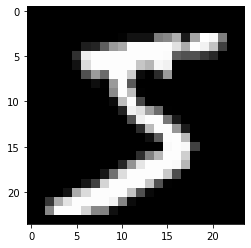

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import mnist_loader

train_images, train_labels = mnist_loader.load_mnist(section = 'training', path = 'MNIST')
test_images, test_labels = mnist_loader.load_mnist(section = 'testing', path = 'MNIST')

train_images = train_images[:,None,2:-2,2:-2]
test_images = test_images[:,None,2:-2,2:-2]

plt.imshow(train_images[0,0], cmap='gray', interpolation = 'nearest')
plt.show()

In [2]:
def run_epoch(batch_size, data, labels, xnode, ynode, probnode, lossnode=None):
    num_samples = len(data)
    total_err = 0.0
    total_loss = 0.0
    num_batches = num_samples//batch_size
    p = np.random.permutation(len(train_images))
    shuffled_train_images = train_images[p]
    shuffled_train_labels = train_labels[p]
    for i in range(num_batches):
        start, end = i*batch_size, (i+1)*batch_size
        xnode.value = shuffled_train_images[start:end]
        ynode.value = shuffled_train_labels[start:end]
        edf.Forward()
        total_err += np.sum(np.not_equal(np.argmax(probnode.value, axis=1), ynode.value))
        if lossnode:
            total_loss += lossnode.value.mean()
            edf.Backward(lossnode)
            edf.SGD()
        if i>0 and i%400 == 0:
            print ("\t Batch {}/{}".format(i, num_batches))
    return 100*total_err/num_samples

def train(num_epochs, batch_size, xnode, ynode, probnode, lossnode):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        train_err = run_epoch(batch_size, train_images, train_labels, xnode, ynode, probnode, lossnode)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))
        test_err = run_epoch(batch_size, test_images, test_labels, xnode, ynode, probnode)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log

In [3]:
class Reshape(edf.CompNode):
    def __init__(self, x, size):
        edf.CompNodes.append(self)
        self.x = x
        self.size = size

    def forward(self):
        self.value = self.x.value.reshape(self.x.value.shape[0], *self.size)
        
    def backward(self):
        self.x.addgrad(self.grad.reshape(self.x.value.shape))

class Affine(edf.CompNode):
    def __init__(self, x, in_feats, out_feats):
        edf.CompNodes.append(self)
        X = edf.Xavier(in_feats)
        self.w = edf.Parameter(np.random.uniform(-X,X,(in_feats,out_feats)))
        self.x = x

    def forward(self):
        self.value = self.x.value @ self.w.value

    def backward(self):
        self.x.addgrad(self.grad @ self.w.value.transpose())
        dw = (np.expand_dims(self.x.value, -1) * np.expand_dims(self.grad, -2)).reshape(-1, *self.w.value.shape)
        self.w.addgrad(dw)
        
class ReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        self.value = np.maximum(0, self.x.value)

    def backward(self):
        self.x.addgrad(np.greater(self.x.value, 0) * self.grad)
        
class Transpose(edf.CompNode):
    def __init__(self, x, dim1, dim2):
        edf.CompNodes.append(self)
        self.x = x
        self.dim1, self.dim2 = dim1, dim2

    def forward(self):
        self.value = self.x.value.swapaxes(self.dim1, self.dim2)
        
    def backward(self):
        self.x.addgrad(self.grad.swapaxes(self.dim1, self.dim2))
        
class BatchedMatmul(edf.CompNode):
    def __init__(self, x1, x2):
        edf.CompNodes.append(self)
        self.x1 = x1
        self.x2 = x2

    def forward(self):
        self.value = self.x1.value @ self.x2.value
        
    def backward(self):
        self.x1.addgrad(self.grad @ self.x2.value.swapaxes(-1,-2))
        self.x2.addgrad(self.x1.value.swapaxes(-1,-2) @ self.grad)
        
class Sum(edf.CompNode):
    def __init__(self, x1, x2):
        edf.CompNodes.append(self)
        self.x1 = x1
        self.x2 = x2

    def forward(self):
        self.value = self.x1.value + self.x2.value
        
    def backward(self):
        self.x1.addgrad(self.grad)
        self.x2.addgrad(self.grad)
        
class Softmax(edf.CompNode):
    def __init__(self, s):
        edf.CompNodes.append(self)
        self.s = s
        
    def forward(self):
        smax = np.max(self.s.value,axis=-1,keepdims=True)
        bounded = np.maximum(-10,self.s.value - smax)
        es = np.exp(bounded) 
        self.value = es / np.sum(es,axis=-1,keepdims=True)

    def backward(self):
        p_dot_pgrad = np.matmul(np.expand_dims(self.value, -2), np.expand_dims(self.grad, -1)).squeeze(-1)
        self.s.addgrad(self.value * (self.grad - p_dot_pgrad))

In [4]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
    N, C, H, W = x_shape
    out_height = int((H + 2 * padding - field_height) / stride + 1)
    out_width = int((W + 2 * padding - field_width) / stride + 1)
    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)
    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)
    return (k, i, j)

def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1, stride=1):
    N, C, H, W = x_shape
    H_padded, W_padded = H + 2 * padding, W + 2 * padding
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding, stride)
    cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
    cols_reshaped = cols_reshaped.transpose(2, 0, 1)
    np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
    if padding == 0: return x_padded
    return x_padded[:, :, padding:-padding, padding:-padding]

def im2col_indices(x, field_height, field_width, padding=1, stride=1):
    p = padding
    x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode="constant")
    k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)
    cols = x_padded[:, k, i, j]
    C = x.shape[1]
    cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
    return cols

class Conv(edf.CompNode):
    def __init__(self, x, in_channels, out_channels, k, padding, stride):
        edf.CompNodes.append(self)
        self.in_channels, self.out_channels, self.k, self.padding, self.stride = in_channels, out_channels, k, padding, stride
        gain = edf.Xavier(self.in_channels * self.k**2)
        self.w = edf.Parameter(np.random.uniform(-gain,gain,(out_channels, in_channels, k, k)))
        self.x = x

    def forward(self):
        N, _, height, width = self.x.value.shape
        out_height = (height + 2 * self.padding - self.k) // self.stride + 1
        out_width = (width + 2 * self.padding - self.k) // self.stride + 1
        self.x_cols = im2col_indices(self.x.value, self.k, self.k, padding=self.padding, stride=self.stride)
        W_col = self.w.value.reshape(self.out_channels, -1)
        out = W_col @ self.x_cols
        out = out.reshape(self.out_channels, out_height, out_width, N)
        self.value = out.transpose(3, 0, 1, 2)

    def backward(self):
        dout_reshaped = self.grad.transpose(1, 2, 3, 0).reshape(self.out_channels, -1)
        dw = dout_reshaped.dot(self.x_cols.T).reshape(self.w.value.shape)[None,:]
        dx_cols = self.w.value.reshape(self.out_channels, -1).T.dot(dout_reshaped)
        dx = col2im_indices(dx_cols, self.x.value.shape, self.k, self.k, self.padding, self.stride)
        self.x.addgrad(dx)
        self.w.addgrad(dw)

In [ ]:
np.random.seed(1234)
batch_size = 64
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()

def CNN(x, y):
    u = ReLU(Conv(x, 1, 4, 3, 1, 2))
    u = ReLU(Conv(u, 4, 8, 3, 1, 2))
    u = ReLU(Conv(u, 8, 16, 3, 1, 2))
    u = Conv(u, 16, 10, 3, 0, 1)
    u = Reshape(u, (10,))
    probnode = edf.Softmax(u)
    lossnode = edf.LogLoss(probnode, ynode)
    return probnode, lossnode

probnode, lossnode = CNN(xnode, ynode)

num_epochs = 10
edf.learning_rate = 0.5
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

In [5]:
class LayerNorm(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        mu = self.x.value.mean((1,2), keepdims=True)
        self.std = self.x.value.std((1,2), keepdims=True)
        self.value = (self.x.value - mu) / self.std
        
    def backward(self):
        grad = (1/self.std) * (self.grad - self.grad.mean((1,2), keepdims=True) - self.grad * (self.grad * self.value).mean((1,2), keepdims=True))
        self.x.addgrad(grad)
        
def SelfAttention(x, in_dim, att_dim):
    q = Affine(x, in_dim, att_dim)
    k = Affine(x, in_dim, att_dim)
    v = Affine(x, in_dim, att_dim)
    
    att = BatchedMatmul(q, Transpose(k, 1, 2))
    att_softmax = Softmax(att)
    h = BatchedMatmul(att_softmax, v)
    
    out = Affine(h, att_dim, in_dim)
    
    return out

In [6]:
def TransformerLayer(x, in_dim, att_dim):
    u = Sum(SelfAttention(LayerNorm(x), in_dim, att_dim), x)
    out = Sum(Affine(ReLU(Affine(LayerNorm(u), in_dim, 2*in_dim)), 2*in_dim, in_dim), u)
    return out

In [7]:
np.random.seed(1234)
batch_size = 64
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()

dim = 32
patch_size = 8
seq_len = (24 // patch_size)**2

u = Conv(xnode, 1, dim, patch_size, 0, patch_size)
u = Reshape(u, (dim, seq_len))
u = Transpose(u, 1, 2)

u = TransformerLayer(u, dim, dim)
u = TransformerLayer(u, dim, dim)

u = Reshape(u, (seq_len*dim,))
scores = Affine(u, seq_len*dim, 10)

probnode = edf.Softmax(scores)
lossnode = edf.LogLoss(probnode, ynode)

num_epochs = 10
edf.learning_rate = 0.05
train_err_log, test_err_log = train(num_epochs, batch_size, xnode, ynode, probnode, lossnode)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.32 %
	 Test Error 6.46 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.97 %
	 Test Error 4.02 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.84 %
	 Test Error 3.17 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.24 %
	 Test Error 2.81 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.90 %
	 Test Error 2.81 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.62 %
	 Test Error 2.21 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.31 %
	 Test Error 1.91 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.15 %
	 Test Error 1.73 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.06 %
	 Test Error 1.96 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.96 %
	 Test Error 1.87 %
